In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

sns.set_theme(style="whitegrid", font_scale=1.5)

In [3]:
def add_noise(X, noise_level=0.1):
    """Add Gaussian noise to numeric features."""
    noise = np.random.normal(loc=0.0, scale=noise_level, size=X.shape)
    return X + noise

def evaluate_model(model, X, y):
    """Evaluate the model and return performance metrics."""
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    return accuracy, f1, precision, recall

def robustness(xgb_sp, rf_sp, mlp_sp, data, label):
    metrics = pd.DataFrame()
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    noise_levels = np.linspace(0, 1.0, 11)
    for noise_level in noise_levels:
        for itrain, itest in kfold.split(data.index.unique().values):
          train_index = data.index.unique()[itrain]
          test_index = data.index.unique()[itest]
          print(train_index)
          print(test_index)
          train = data.loc[train_index]
          test = data.loc[test_index]

          X_noisy = add_noise(test.drop(columns=['statistical_parity', 'equal_opportunity', 'average_odds']), noise_level)
          y_train = train[label]
          y_test = test[label]
          results = {}
          results['noise_level'] = noise_level
          # Evaluate each model
          for model, name in zip([xgb_sp, rf_sp, mlp_sp], ['XGB', 'RF', 'MLP']):
              model.fit(train.drop(columns=['statistical_parity', 'equal_opportunity', 'average_odds']), y_train)
              accuracy, f1, precision, recall = evaluate_model(model, X_noisy, y_test)
              results['model'] = name
              results['accuracy'] = accuracy
              results['f1'] = f1
              results['precision'] = precision
              results['recall'] = recall
              metrics = pd.concat([metrics, pd.DataFrame([results])], ignore_index=True)
    return metrics

data = pd.read_csv('../data/bias_symptoms_logreg_reduced.csv', index_col=[0,1])
data.index = data.index.droplevel(1)


In [4]:
data

,correlation_true,mutual_info,unpriv_prob_pos,unpriv_unbalance,priv_unbalance,statistical_parity,equal_opportunity,average_odds,skew_var,gini,simpson,shannon,ir,pos_prob
data,,,,,,,,,,,,,,
arrhythmia,-0.329830,0.263048,0.250000,0.575000,1.326923,0.0,0.0,0.0,-0.272071,0.080404,0.029740,0.999956,0.769208,0.326923
arrhythmia,0.071520,0.075555,0.454545,1.045455,0.000000,1.0,1.0,1.0,4.629568,0.110091,0.016495,0.999949,0.045361,0.454545
arrhythmia,0.152653,0.042323,0.444444,1.022222,0.000000,1.0,1.0,1.0,6.782330,0.111328,0.015795,0.999947,0.022126,0.444444
arrhythmia,0.021056,0.055834,0.444444,1.022222,0.000000,1.0,1.0,1.0,6.782330,0.111328,0.015795,0.999947,0.022126,0.444444
arrhythmia,0.110542,0.104732,0.444444,1.022222,0.000000,1.0,1.0,1.0,6.782330,0.111328,0.015795,0.999947,0.022126,0.444444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ibm,-0.095871,0.005095,0.798319,0.977941,1.093750,0.0,0.0,0.0,1.592781,0.101727,0.002141,0.999786,0.235219,0.094538
ibm,-0.058910,0.001746,0.794872,0.973718,1.029710,0.0,0.0,0.0,0.123947,0.085857,0.002951,0.999796,0.884604,0.045708
ibm,0.141521,0.009645,0.855670,1.048196,0.906500,0.0,1.0,0.0,0.681858,0.093211,0.002687,0.999794,0.515416,0.115670


## Statistical Parity

In [5]:
mlp_sp = MLPClassifier(alpha=0.0001, hidden_layer_sizes=(50,), learning_rate='constant', learning_rate_init=0.01, max_iter=200)
rf_sp = RandomForestClassifier(max_depth=10, max_features='log2', min_samples_leaf=1, min_samples_split=10, n_estimators=500)
xgb_sp = XGBClassifier(colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=6, subsample=0.6)

In [6]:
metrics = pd.DataFrame()
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
noise_levels = np.linspace(0, 1.0, 11)

for noise_level in noise_levels:
    for itrain, itest in kfold.split(data.index.unique().values):
      train_index = data.index.unique()[itrain]
      test_index = data.index.unique()[itest]
      print(train_index)
      print(test_index)
      train = data.loc[train_index]
      test = data.loc[test_index]

      X_noisy = add_noise(test.drop(columns=['statistical_parity', 'equal_opportunity', 'average_odds']), noise_level)
      y_train = train['statistical_parity']
      y_test = test['statistical_parity']
      results = {}
      results['noise_level'] = noise_level
      # Evaluate each model
      accuracy_list = []
      f1_list = []
      precision_list = []
      recall_list = []
      for model, name in zip([xgb_sp, rf_sp, mlp_sp], ['XGB', 'RF', 'MLP']):
          model.fit(train.drop(columns=['statistical_parity', 'equal_opportunity', 'average_odds']), y_train)
          accuracy, f1, precision, recall = evaluate_model(model, X_noisy, y_test)
          results['model'] = name
          results['accuracy'] = accuracy
          results['f1'] = f1
          results['precision'] = precision
          results['recall'] = recall
          metrics = pd.concat([metrics, pd.DataFrame([results])], ignore_index=True)
    

Index(['german', 'student', 'adult', 'park', 'wine', 'placement', 'hearth',
       'resyduo', 'us', 'law', 'medical', 'vaccine', 'compas', 'ricci', 'bank',
       'health', 'diabetic', 'crime', 'ibm'],
      dtype='object', name='data')
Index(['arrhythmia', 'drug', 'cmc', 'obesity', 'credit'], dtype='object', name='data')
Index(['arrhythmia', 'student', 'adult', 'park', 'placement', 'hearth', 'drug',
       'us', 'cmc', 'law', 'vaccine', 'compas', 'obesity', 'ricci', 'credit',
       'bank', 'health', 'crime', 'ibm'],
      dtype='object', name='data')
Index(['german', 'wine', 'resyduo', 'medical', 'diabetic'], dtype='object', name='data')
Index(['arrhythmia', 'german', 'wine', 'placement', 'hearth', 'drug',
       'resyduo', 'us', 'cmc', 'medical', 'vaccine', 'obesity', 'ricci',
       'credit', 'bank', 'health', 'diabetic', 'crime', 'ibm'],
      dtype='object', name='data')
Index(['student', 'adult', 'park', 'law', 'compas'], dtype='object', name='data')
Index(['arrhythmia', 'german

In [7]:
metrics_melt_sp = metrics.melt(id_vars=['noise_level', 'model'],
                          value_vars=['accuracy', 'f1', 'precision', 'recall'],
                          var_name='metric', value_name='value')

In [8]:
metrics_melt_sp['fairness'] = 'Statistical Parity'

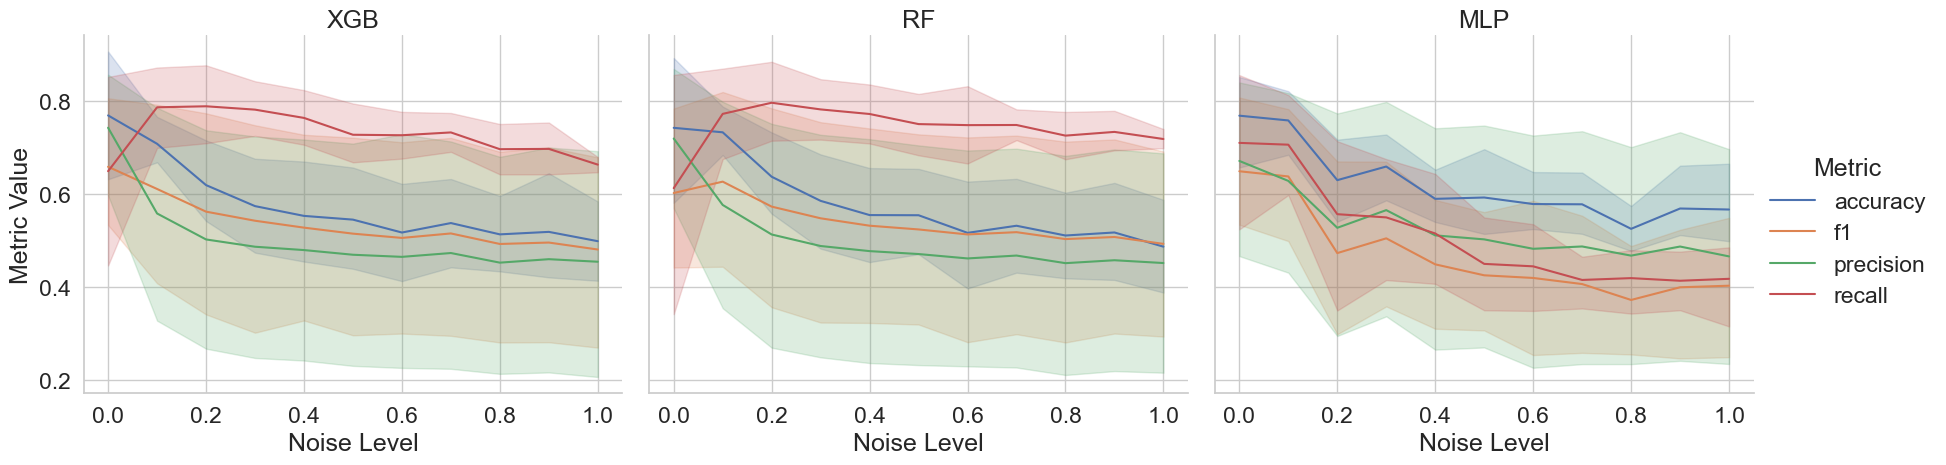

In [9]:
g = sns.relplot(
    data=metrics_melt_sp[metrics_melt_sp['metric'].isin(['f1', 'precision', 'accuracy', 'recall'])],
    x='noise_level',
    y='value',
    hue='metric',
    col='model',
    kind='line',
    height=5,
    aspect=1.2,
    facet_kws={'sharey': True, 'sharex': True},
    col_wrap=3
)

g.set_axis_labels("Noise Level", "Metric Value")
g.set_titles(col_template="{col_name}")
g.legend.set_title("Metric")
plt.savefig('model_robustness_sp.pdf', bbox_inches='tight')


## Equal Opportunity

In [ ]:
mlp_sp = MLPClassifier(alpha=0.0001, hidden_layer_sizes=(50,), learning_rate='constant', learning_rate_init=0.01, max_iter=200)
rf_sp = RandomForestClassifier(max_depth=10, max_features='log2', min_samples_leaf=1, min_samples_split=10, n_estimators=500)
xgb_sp = XGBClassifier(colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=6, subsample=0.6)

In [11]:
metrics_eo = robustness(xgb_sp, rf_sp, mlp_sp, data, 'equal_opportunity')

Index(['german', 'student', 'adult', 'park', 'wine', 'placement', 'hearth',
       'resyduo', 'us', 'law', 'medical', 'vaccine', 'compas', 'ricci', 'bank',
       'health', 'diabetic', 'crime', 'ibm'],
      dtype='object', name='data')
Index(['arrhythmia', 'drug', 'cmc', 'obesity', 'credit'], dtype='object', name='data')
Index(['arrhythmia', 'student', 'adult', 'park', 'placement', 'hearth', 'drug',
       'us', 'cmc', 'law', 'vaccine', 'compas', 'obesity', 'ricci', 'credit',
       'bank', 'health', 'crime', 'ibm'],
      dtype='object', name='data')
Index(['german', 'wine', 'resyduo', 'medical', 'diabetic'], dtype='object', name='data')
Index(['arrhythmia', 'german', 'wine', 'placement', 'hearth', 'drug',
       'resyduo', 'us', 'cmc', 'medical', 'vaccine', 'obesity', 'ricci',
       'credit', 'bank', 'health', 'diabetic', 'crime', 'ibm'],
      dtype='object', name='data')
Index(['student', 'adult', 'park', 'law', 'compas'], dtype='object', name='data')
Index(['arrhythmia', 'german

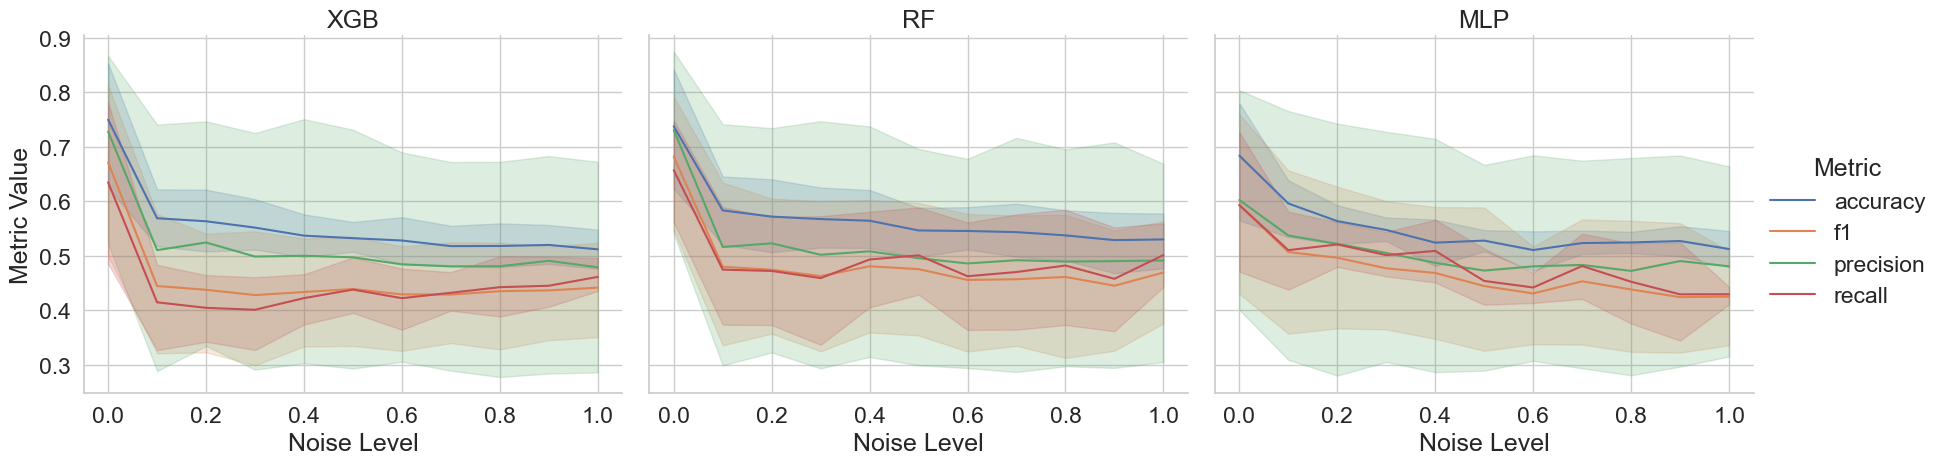

In [12]:
metrics_melt_eo = metrics_eo.melt(id_vars=['noise_level', 'model'],
                          value_vars=['accuracy', 'f1', 'precision', 'recall'],
                          var_name='metric', value_name='value')

g = sns.relplot(
    data=metrics_melt_eo,
    x='noise_level',
    y='value',
    hue='metric',
    col='model',
    kind='line',
    height=5,
    aspect=1.2,
    facet_kws={'sharey': True, 'sharex': True},
    col_wrap=3
)

g.set_axis_labels("Noise Level", "Metric Value")
g.set_titles(col_template="{col_name}")
g.legend.set_title("Metric")
plt.savefig('model_robustness_eo.pdf', bbox_inches='tight')


## Average Odds

In [17]:
xgb_ao = load('../../ml_models/data_xgb_average_odds.joblib')
rf_ao = load('../../ml_models/data_rf_average_odds.joblib')
mlp_ao = load('../../ml_models/data_mlp_average_odds.joblib')

In [ ]:
metrics_ao = robustness(xgb_sp, rf_sp, mlp_sp, data, 'average_odds')

Index(['german', 'student', 'adult', 'park', 'wine', 'placement', 'hearth',
       'resyduo', 'us', 'law', 'medical', 'vaccine', 'compas', 'ricci', 'bank',
       'health', 'diabetic', 'crime', 'ibm'],
      dtype='object', name='data')
Index(['arrhythmia', 'drug', 'cmc', 'obesity', 'credit'], dtype='object', name='data')
Index(['arrhythmia', 'student', 'adult', 'park', 'placement', 'hearth', 'drug',
       'us', 'cmc', 'law', 'vaccine', 'compas', 'obesity', 'ricci', 'credit',
       'bank', 'health', 'crime', 'ibm'],
      dtype='object', name='data')
Index(['german', 'wine', 'resyduo', 'medical', 'diabetic'], dtype='object', name='data')
Index(['arrhythmia', 'german', 'wine', 'placement', 'hearth', 'drug',
       'resyduo', 'us', 'cmc', 'medical', 'vaccine', 'obesity', 'ricci',
       'credit', 'bank', 'health', 'diabetic', 'crime', 'ibm'],
      dtype='object', name='data')
Index(['student', 'adult', 'park', 'law', 'compas'], dtype='object', name='data')
Index(['arrhythmia', 'german

/Users/giord/miniconda3/envs/ds/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Index(['arrhythmia', 'german', 'student', 'adult', 'park', 'wine', 'placement',
       'drug', 'resyduo', 'us', 'cmc', 'law', 'medical', 'vaccine', 'compas',
       'obesity', 'credit', 'bank', 'diabetic'],
      dtype='object', name='data')
Index(['hearth', 'ricci', 'health', 'crime', 'ibm'], dtype='object', name='data')
Index(['arrhythmia', 'german', 'student', 'adult', 'park', 'wine', 'hearth',
       'drug', 'resyduo', 'cmc', 'law', 'medical', 'compas', 'obesity',
       'ricci', 'credit', 'health', 'diabetic', 'crime', 'ibm'],
      dtype='object', name='data')
Index(['placement', 'us', 'vaccine', 'bank'], dtype='object', name='data')
Index(['german', 'student', 'adult', 'park', 'wine', 'placement', 'hearth',
       'resyduo', 'us', 'law', 'medical', 'vaccine', 'compas', 'ricci', 'bank',
       'health', 'diabetic', 'crime', 'ibm'],
      dtype='object', name='data')
Index(['arrhythmia', 'drug', 'cmc', 'obesity', 'credit'], dtype='object', name='data')
Index(['arrhythmia', 'studen

/Users/giord/miniconda3/envs/ds/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Index(['arrhythmia', 'student', 'adult', 'park', 'placement', 'hearth', 'drug',
       'us', 'cmc', 'law', 'vaccine', 'compas', 'obesity', 'ricci', 'credit',
       'bank', 'health', 'crime', 'ibm'],
      dtype='object', name='data')
Index(['german', 'wine', 'resyduo', 'medical', 'diabetic'], dtype='object', name='data')
Index(['arrhythmia', 'german', 'wine', 'placement', 'hearth', 'drug',
       'resyduo', 'us', 'cmc', 'medical', 'vaccine', 'obesity', 'ricci',
       'credit', 'bank', 'health', 'diabetic', 'crime', 'ibm'],
      dtype='object', name='data')
Index(['student', 'adult', 'park', 'law', 'compas'], dtype='object', name='data')
Index(['arrhythmia', 'german', 'student', 'adult', 'park', 'wine', 'placement',
       'drug', 'resyduo', 'us', 'cmc', 'law', 'medical', 'vaccine', 'compas',
       'obesity', 'credit', 'bank', 'diabetic'],
      dtype='object', name='data')
Index(['hearth', 'ricci', 'health', 'crime', 'ibm'], dtype='object', name='data')
Index(['arrhythmia', 'german

In [1]:
metrics_melt_ao = metrics_ao.melt(id_vars=['noise_level', 'model'],
                          value_vars=['accuracy', 'f1', 'precision', 'recall'],
                          var_name='metric', value_name='value')

g = sns.relplot(
    data=metrics_melt_ao,
    x='noise_level',
    y='value',
    hue='metric',
    col='model',
    kind='line',
    height=5,
    aspect=1.2,
    facet_kws={'sharey': True, 'sharex': True},
    col_wrap=3
)

g.set_axis_labels("Noise Level", "Metric Value")
g.set_titles(col_template="{col_name}")
g.legend.set_title("Metric")

NameError: name 'metrics_ao' is not defined

## Full Results

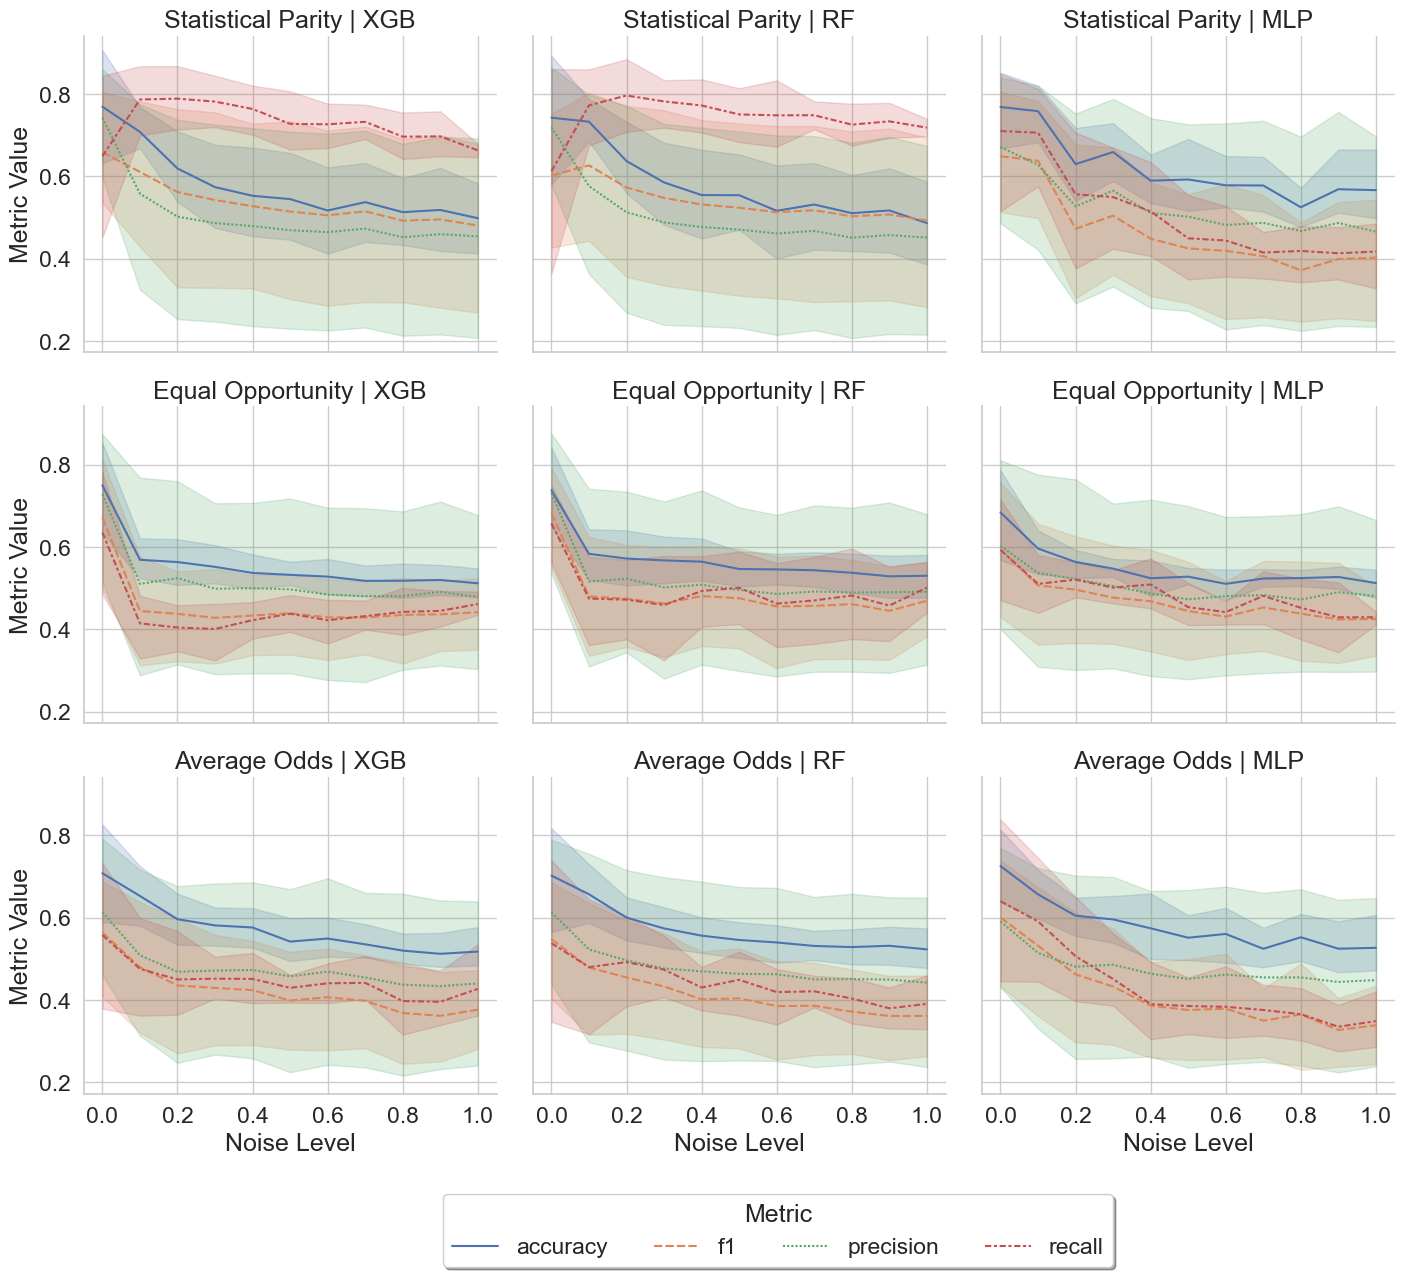

In [16]:
metrics_melt_sp['fairness'] = 'Statistical Parity'
metrics_melt_eo['fairness'] = 'Equal Opportunity'
metrics_melt_ao['fairness'] = 'Average Odds'
metrics_combined = pd.concat([metrics_melt_sp, metrics_melt_eo, metrics_melt_ao], ignore_index=True)
g = sns.relplot(
    data=metrics_combined[metrics_combined['metric'].isin(['f1', 'precision', 'accuracy', 'recall'])],
    x='noise_level',
    y='value',
    hue='metric',
    style='metric',
    col='model',
    row='fairness',
    kind='line',
    height=4,
    aspect=1.2,
    facet_kws={'sharey': True, 'sharex': True},
)
g.set_axis_labels("Noise Level", "Metric Value")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
sns.move_legend(g, "lower center", bbox_to_anchor=(0.5, -0.08), ncol=4, title="Metric", shadow=True, frameon=True)
plt.savefig('model_robustness_combined.pdf', bbox_inches='tight')
plt.show()